<a href="https://colab.research.google.com/github/f-brockman/fastai_projects/blob/main/front_work_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
library('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
survey_raw <- read.csv('/content/nps_survey.csv') %>%
   as_tibble %>%
   mutate(
  created_at = as.Date(created_at)
  ,surveyed_at = as.Date(surveyed_at)
   )

head(survey_raw)

is_admin,id,score,created_at,surveyed_at,sessions,messages
<int>,<int>,<int>,<date>,<date>,<int>,<int>
1,1474,9,2017-01-01,2017-02-01,4,8
1,1129,10,2017-01-01,2017-02-01,3,8
0,3337,10,2017-01-01,2017-02-01,9,42
1,1873,1,2017-01-01,2017-02-01,35,135
0,2720,9,2017-01-01,2017-02-01,4,13
0,5309,8,2017-01-01,2017-02-01,21,72


**Questions to Address**

1. Compute the NPS of all the monthly cohorts, grouped by date of creation of the user.
2. Display the trend of NPS over time by month for the 3 following segments: all users; admins only; regular users only.
3. How can you explain the paradoxical trends in Front’s NPS surfaced in the above question?

**Data Validation**

In [4]:
#flag potential issues with 1
survey_issues <- survey_raw %>%
  mutate(
  date_issue = case_when(
    surveyed_at <= created_at ~ 1
    ,TRUE ~ 0
  )
  ,score_issue = case_when(
    score > 10 | score < 0 ~ 1
    ,TRUE ~ 0
  )
  )

 survey_issues %>%
  filter(
  date_issue == 1 | score_issue == 1
  )



is_admin,id,score,created_at,surveyed_at,sessions,messages,date_issue,score_issue
<int>,<int>,<int>,<date>,<date>,<int>,<int>,<dbl>,<dbl>


In [5]:
#see if mins/max/medians seem reasonable, i think they do
survey_raw %>%
  select(created_at, surveyed_at, sessions, messages) %>%
  summary()


   created_at          surveyed_at            sessions         messages    
 Min.   :2017-01-01   Min.   :2017-02-01   Min.   :  3.00   Min.   :  0.0  
 1st Qu.:2017-08-22   1st Qu.:2017-09-22   1st Qu.:  7.00   1st Qu.: 20.0  
 Median :2018-01-19   Median :2018-02-19   Median : 20.00   Median : 56.0  
 Mean   :2017-12-20   Mean   :2018-01-19   Mean   : 36.54   Mean   :109.5  
 3rd Qu.:2018-05-07   3rd Qu.:2018-06-07   3rd Qu.: 55.00   3rd Qu.:153.0  
 Max.   :2018-07-31   Max.   :2018-08-31   Max.   :148.00   Max.   :827.0  

In [6]:
#distinct ids?
nrow(survey_raw) == length(unique(survey_raw$id))

[1] TRUE

**1. Compute the NPS of all the monthly cohorts, grouped by date of creation of the user.**

NPS = (# of promoters - # of detractors) / # of surveys * 100

Promoter = gave a score of 9 or 10

Detractor = gave a score of 0 to 6

In [7]:
survey <- survey_raw %>%
  mutate(
  created_month = month(created_at)
  ,created_year = year(created_at)
  ,promoter = case_when(
    score >= 9 ~ 1
    ,TRUE ~ 0
  )
  ,detractor = case_when(
    score <= 6 ~ 1
    ,TRUE ~ 0
  )
  )

survey_counts <- survey %>%
  group_by(created_month, created_year, is_admin) %>%
  summarise(
  survey_count = n()
  ,promoter_count = sum(promoter)
  ,detractor_count = sum(detractor)
   ) %>%
    arrange(created_year,created_month)

 is_admin_nps <- survey_counts %>%
   mutate(
    nps = round(((promoter_count - detractor_count) / survey_count)*100,2)
   )

all_nps <- survey_counts %>%
      group_by(created_month,created_year) %>%
      summarise(
      promoter_count = sum(promoter_count)
      ,detractor_count = sum(detractor_count)
      ,survey_count = sum(survey_count)
      ,nps = round(((promoter_count - detractor_count) / survey_count)*100,2
      )) %>%
      #using 2 as a placeholder for all, regardless of is_admin
      mutate(is_admin = 2)%>%
      rbind(is_admin_nps) %>%
      arrange(created_year,created_month,is_admin)


monthly_summary <- all_nps %>%
  filter(is_admin == 2) %>%
  select(
    created_month
    ,created_year
    ,survey_count
    ,nps
  )

monthly_summary

`summarise()` has grouped output by 'created_month', 'created_year'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'created_month'. You can override using the
`.groups` argument.


created_month,created_year,survey_count,nps
<dbl>,<dbl>,<int>,<dbl>
1,2017,500,13.00
2,2017,535,14.02
3,2017,579,12.95
4,2017,629,11.92
5,2017,685,12.99
6,2017,727,11.97
7,2017,792,11.99
8,2017,870,10.00
9,2017,915,11.04


created_month,created_year,promoter_count,detractor_count,survey_count,nps,is_admin,created_date,admin_category
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<date>,<chr>
1,2017,92,114,250,-8.8,0,2017-01-01,Regular Users Only
1,2017,164,77,250,34.8,1,2017-01-01,Admins Only


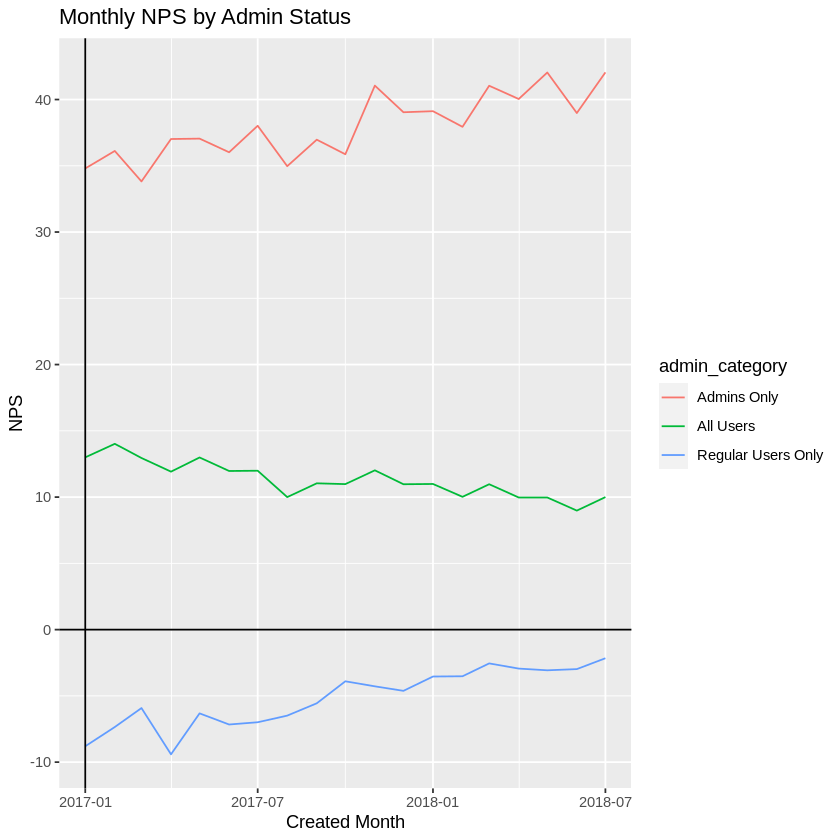

In [26]:
# prompt: create a date from created_month and created_year starting the first day of the month

for_chart <- all_nps %>%
  mutate(
    created_date = make_date(created_year, created_month, 1)
    ,admin_category = case_when(
      is_admin == 1 ~ 'Admins Only'
      ,is_admin == 0 ~ 'Regular Users Only'
      ,TRUE ~ 'All Users'
    )
  )

p <- ggplot(for_chart, aes(x = created_date, y = nps, color = admin_category)) +
  geom_line()+
  labs(
  title = 'Monthly NPS by Admin Status'
  ,x = 'Created Month'
  ,y = 'NPS'
  ) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = as.Date('2017-01-01'))

head(for_chart,2)
p

**3. How can you explain the paradoxical trends in Front’s NPS surfaced in the above question?**

Why does All Users NPS seem to decrease although Admins and Regular Users appears to increase?


In [9]:
nps_counts <- for_chart %>%
  mutate(
    middle_count = survey_count - (promoter_count + detractor_count)
  )

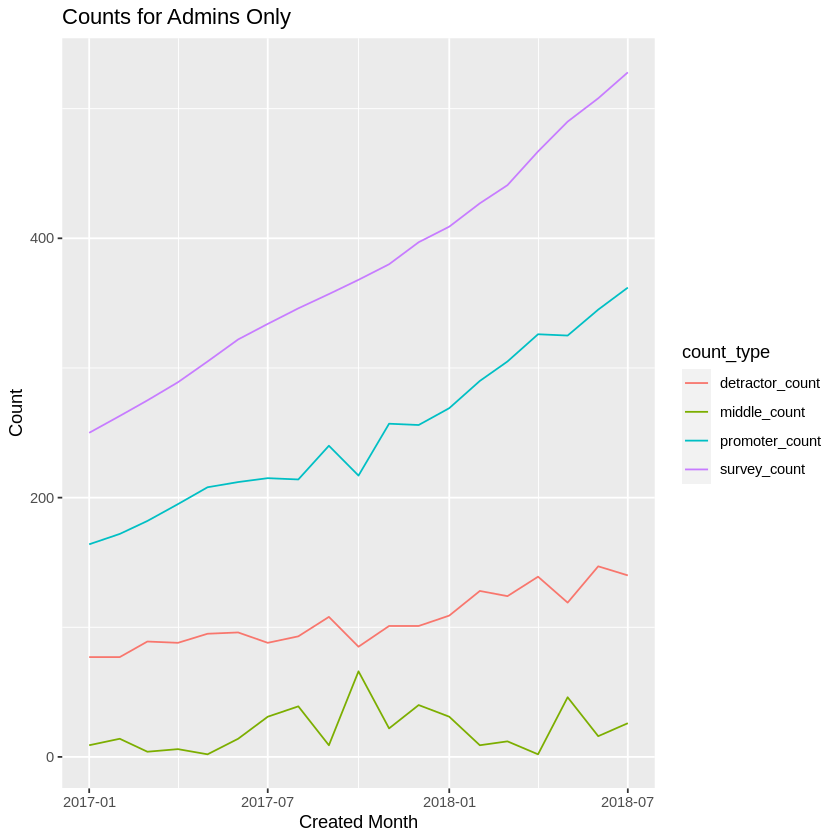

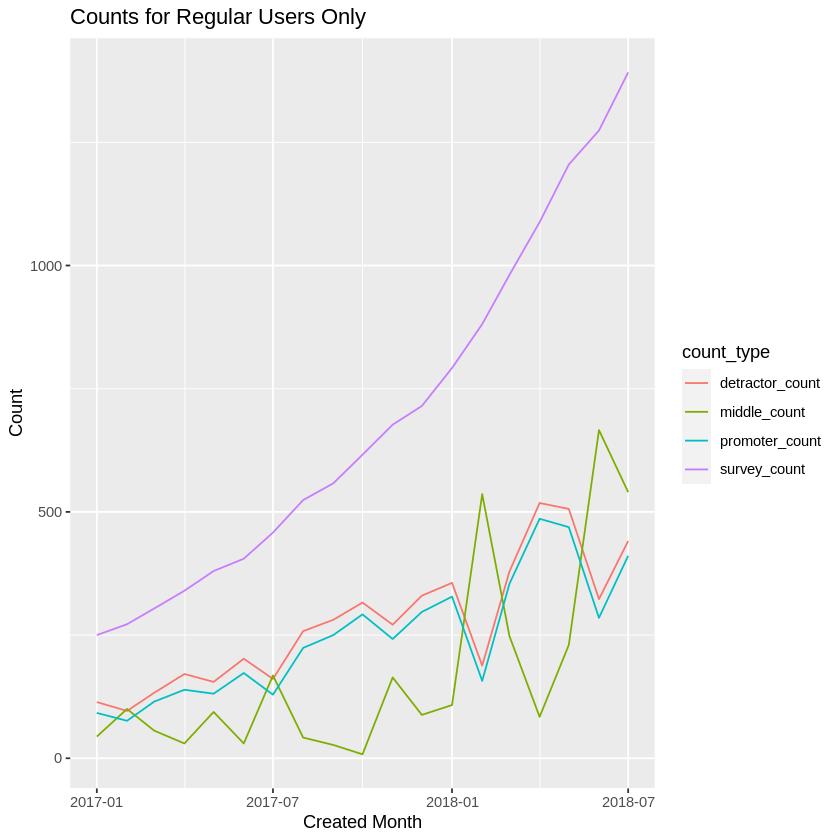

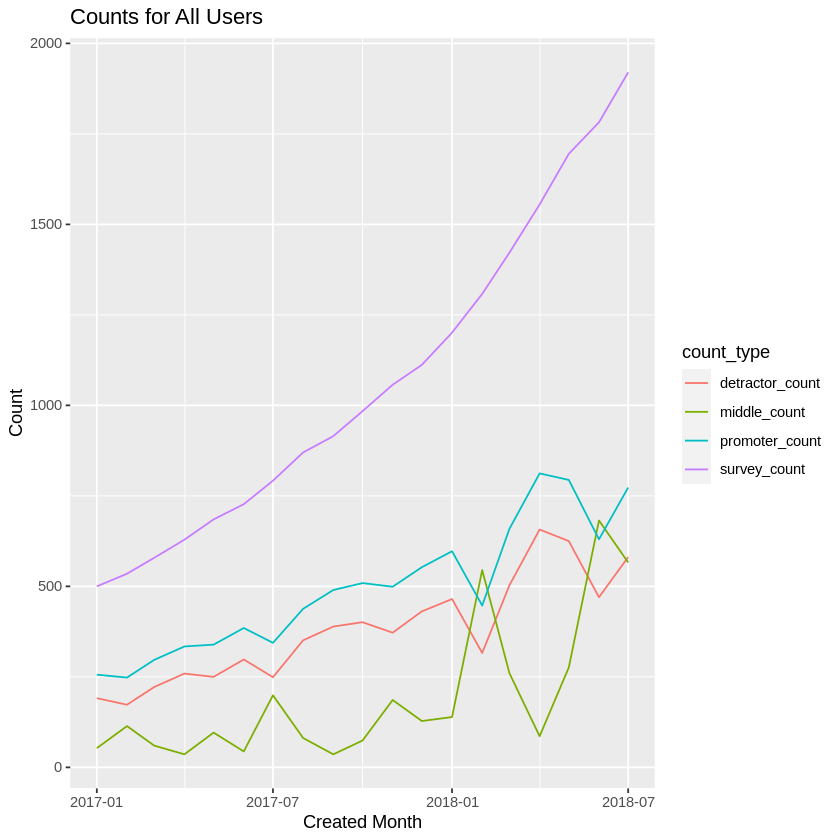

In [10]:
chart_nps_counts <- function(admin_category) {
  nps_counts %>%
    filter(admin_category == !!admin_category) %>%
    pivot_longer(
      cols = c('survey_count', 'promoter_count', 'detractor_count', 'middle_count'),
      names_to = 'count_type',
      values_to = 'count'
    ) %>%
    ggplot(aes(x = created_date, y = count, color = count_type)) +
    geom_line() +
    labs(
      title = paste('Counts for',admin_category),
      x = 'Created Month',
      y = 'Count'
    )
}

chart_nps_counts('Admins Only')
chart_nps_counts('Regular Users Only')
chart_nps_counts('All Users')


In [20]:
head(nps_counts,3)
tail(nps_counts,3)

created_month,created_year,promoter_count,detractor_count,survey_count,nps,is_admin,created_date,admin_category,middle_count
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<date>,<chr>,<dbl>
1,2017,92,114,250,-8.8,0,2017-01-01,Regular Users Only,44
1,2017,164,77,250,34.8,1,2017-01-01,Admins Only,9
1,2017,256,191,500,13.0,2,2017-01-01,All Users,53


created_month,created_year,promoter_count,detractor_count,survey_count,nps,is_admin,created_date,admin_category,middle_count
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<date>,<chr>,<dbl>
7,2018,411,441,1392,-2.16,0,2018-07-01,Regular Users Only,540
7,2018,362,140,528,42.05,1,2018-07-01,Admins Only,26
7,2018,773,581,1920,10.00,2,2018-07-01,All Users,566


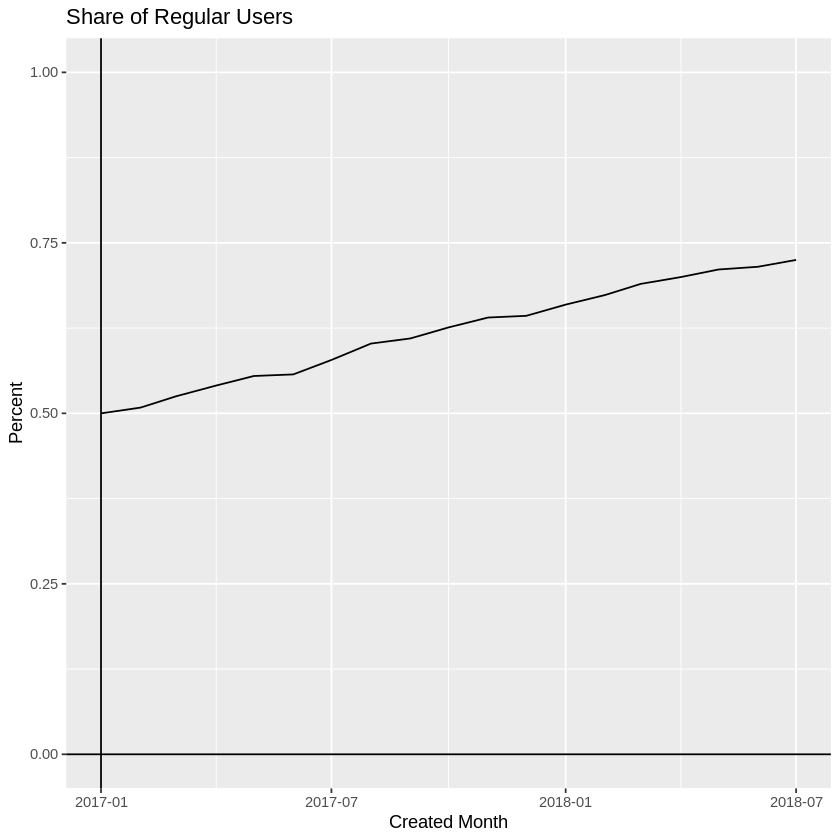

In [27]:
regular_users_only_nps <- nps_counts %>%
  filter(admin_category == 'Regular Users Only')

all_users_nps <- nps_counts %>%
  filter(admin_category == 'All Users')

regular_for_plot <- regular_users_only_nps %>%
  left_join(all_users_nps, by = 'created_date') %>%
  mutate(
    regular_users_only_survey_count_percent = survey_count.x / survey_count.y
  ) %>%
  select(created_date, regular_users_only_survey_count_percent)

plot <- ggplot(regular_for_plot, aes(x = created_date, y = regular_users_only_survey_count_percent)) +
  geom_line()+
  labs(
      title = 'Share of Regular Users',
      x = 'Created Month',
      y = 'Percent'
    )+
      ylim(0,1) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = as.Date('2017-01-01'))


plot

Later All Users NPS are more heavily weighted towards Regular Users, which always have a negative NPS. At the 1/17, the split was 50% / 50%, while at 7/18 the splot was 72.5% / 27.5% for Regular and Admin respectively. This increase in the share of negative NPS in the total drives the average down over time.
